Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL09 AutoEncoder

### Lab Description

This laboratory exercise introduces **AutoEncoders**, a type of neural network architecture used for unsupervised learning of efficient data representations. Autoencoders aim to compress input data into a lower-dimensional latent space and then reconstruct the original input from this compressed form.

In this hands-on lab, your objective is to build and train an autoencoder model capable of removing noise from input images and producing visually clean outputs. You will implement two distinct autoencoder architectures, each based on a different layer type:

- Multilayer Perceptron (MLP)
- Convolutional Neural Network (CNN)

The `MNIST` handwritten digits dataset will be used as the input data. The dataset will be artificially corrupted with noise, and your models will learn to reconstruct clean images from the noisy inputs. The reconstructed outputs should appear noise-free or at least significantly cleaner upon inspection.

### What you can expect to learn

- Theoretical understanding: Understand the structure and purpose of autoencoders in representation learning, denoising, and data compression.  
- Model implementation: Learn to build both MLP-based and CNN-based autoencoder networks using PyTorch.  
- Denoising and visualization: Train autoencoders to clean noisy images and visualize the quality of reconstructed outputs.


In [1]:
!pip install hiredis

### Import necessary libraries

In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
print("GPU Name:", torch.cuda.get_device_name(0))

### Required Dataset
We selected the MNIST digit images as the dataset for this experiment. \
First, we implemented a BinarizeAndNoiseDataset class to add random noise to the MNIST images.

In [3]:
class BinarizeAndNoiseDataset(Dataset):
    def __init__(self, dataset, is_train=True):
        self.dataset = dataset
        self.is_train = is_train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image = (image > 0.5).float()
        noise = torch.randn_like(image) * 0.2
        noisy_image = image + noise
        noisy_image = torch.clamp(noisy_image, 0, 1)
        if self.is_train:
            return noisy_image, image
        else:
            return noisy_image

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

DATA_ROOT = os.path.expanduser("~/data/mnist")
train_raw = datasets.MNIST(root=DATA_ROOT, train=True, download=True, transform=transform)
test_raw = datasets.MNIST(root=DATA_ROOT, train=False, download=True, transform=transform)

train_dataset = BinarizeAndNoiseDataset(train_raw, is_train=True)
test_dataset = BinarizeAndNoiseDataset(test_raw, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Next, we can print out the noisy images to visually inspect the effect.

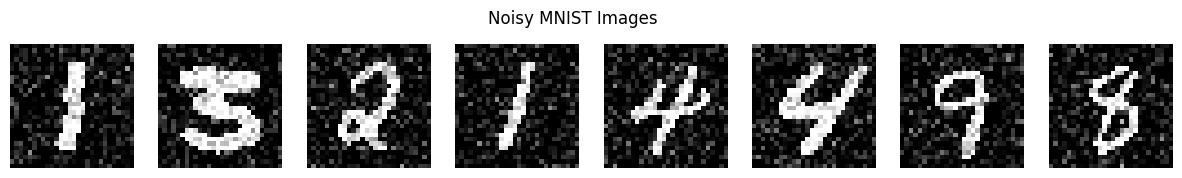

In [5]:
noisy_imgs, clean_imgs = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axes[i].imshow(noisy_imgs[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.suptitle("Noisy MNIST Images")
plt.show()

### CNN Autoencoder
In this block, we will build a CNN autoencoder from scratch. \
You are encouraged to experiment with different layer configurations and compare how each architecture performs.

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.dec1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = self.up(x)
        x = F.relu(self.dec1(x))
        x = self.up(x)
        x = torch.sigmoid(self.dec2(x))
        return x

### MLP Autoencoder
In this block, we will build a MLP autoencoder from scratch. \
You are encouraged to experiment with different layer configurations and compare how each architecture performs.

In [7]:
class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28)),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Choose Model Type
In this section, we select the type of model, either CNN or MLP, for our experiment.

In [9]:
model_type = "mlp"
if model_type == "cnn":
    model = CNN_Autoencoder().to(device)
else:
    model = MLP_Autoencoder().to(device)

### Loss Function

In this experiment, we use BCELoss.

It is commonly used in binary classification tasks or when the output is in the range of [0, 1], such as in image reconstruction tasks with normalized pixel values. BCELoss measures the difference between the predicted probability and the actual binary label for each pixel, encouraging the model to predict values close to the ground truth. It is defined as:

$$
\text{BCELoss}(x, y) = -[y \cdot \log(x) + (1 - y) \cdot \log(1 - x)]
$$

where $x$ is the predicted value and $y$ is the target.

In [10]:
criterion = nn.BCELoss()

### Optimization Algorithm
In this experiment, we use Adam algorithm. Adam (short for Adaptive Moment Estimation) is a popular optimization algorithm used for training deep learning models. \
It combines the benefits of two other methods: AdaGrad and RMSProp. Adam maintains an adaptive learning rate for each parameter by using estimates of both the first-order moment (mean) and the second-order moment (uncentered variance) of the gradients. This allows for faster convergence and better performance in practice, especially for problems with sparse gradients or noisy data.


In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Model Architecture
We can use model.train() to check our current model architecture.

In [12]:
model.train()

MLP_Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

### Start Training

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.1601
Epoch [2/10], Loss: 0.1020
Epoch [3/10], Loss: 0.0847
Epoch [4/10], Loss: 0.0749
Epoch [5/10], Loss: 0.0687


### Evaluate and Show the Results

In [ ]:
model.eval()
with torch.no_grad():
    for noisy_imgs in test_loader:
        noisy_imgs = noisy_imgs.to(device)
        outputs = model(noisy_imgs)
        break

n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_imgs[i].cpu().squeeze(), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].cpu().squeeze(), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")
plt.tight_layout()
plt.show()